[[0.90179956 0.9417195  0.37377474 0.07043936 0.53236914 0.7381097 ]
 [0.5166569  0.40206912 0.8782092  0.26794338 0.8631228  0.28210485]]
Epoch 1, Loss: 1.7332810163497925, Accuracy: 26.488887786865234, Test Accuracy: 28.857717514038086
Epoch 2, Loss: 1.6665451526641846, Accuracy: 32.35555648803711, Test Accuracy: 32.66532897949219
Epoch 3, Loss: 1.6180094480514526, Accuracy: 36.31111145019531, Test Accuracy: 31.46292495727539
Epoch 4, Loss: 1.5753222703933716, Accuracy: 36.733333587646484, Test Accuracy: 32.46493148803711
Epoch 5, Loss: 1.535463809967041, Accuracy: 36.266666412353516, Test Accuracy: 33.46693420410156
Epoch 6, Loss: 1.4999189376831055, Accuracy: 36.088890075683594, Test Accuracy: 34.068138122558594
Epoch 7, Loss: 1.4675507545471191, Accuracy: 36.91111373901367, Test Accuracy: 35.470943450927734
Epoch 8, Loss: 1.4377931356430054, Accuracy: 37.68888854980469, Test Accuracy: 37.474952697753906
Epoch 9, Loss: 1.4098310470581055, Accuracy: 38.82221984863281, Test Accuracy:

Epoch 85, Loss: 0.20882071554660797, Accuracy: 98.77777862548828, Test Accuracy: 95.99198150634766
Epoch 86, Loss: 0.20275646448135376, Accuracy: 98.84444427490234, Test Accuracy: 96.1923828125
Epoch 87, Loss: 0.19685983657836914, Accuracy: 99.0, Test Accuracy: 96.1923828125
Epoch 88, Loss: 0.19113804399967194, Accuracy: 99.13333129882812, Test Accuracy: 96.39278411865234
Epoch 89, Loss: 0.18559902906417847, Accuracy: 99.28888702392578, Test Accuracy: 96.79358673095703
Epoch 90, Loss: 0.18019333481788635, Accuracy: 99.33333587646484, Test Accuracy: 97.39479064941406
Epoch 91, Loss: 0.17493553459644318, Accuracy: 99.4000015258789, Test Accuracy: 97.79559326171875
Epoch 92, Loss: 0.16979728639125824, Accuracy: 99.46666717529297, Test Accuracy: 97.79559326171875
Epoch 93, Loss: 0.16480779647827148, Accuracy: 99.55555725097656, Test Accuracy: 97.79559326171875
Epoch 94, Loss: 0.15995009243488312, Accuracy: 99.5777816772461, Test Accuracy: 97.79559326171875
Epoch 95, Loss: 0.155224069952964

Epoch 177, Loss: 0.012216067872941494, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 178, Loss: 0.011892624199390411, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 179, Loss: 0.011580039747059345, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 180, Loss: 0.011271899566054344, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 181, Loss: 0.010966322384774685, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 182, Loss: 0.010680991224944592, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 183, Loss: 0.01040224265307188, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 184, Loss: 0.010135459713637829, Accuracy: 100.0, Test Accuracy: 99.39879608154297
Epoch 185, Loss: 0.009873486123979092, Accuracy: 100.0, Test Accuracy: 99.59919738769531
Epoch 186, Loss: 0.0096201803535223, Accuracy: 100.0, Test Accuracy: 99.59919738769531
Epoch 187, Loss: 0.009374545887112617, Accuracy: 100.0, Test Accuracy: 99.59919738769531
Epoch 188, Loss: 0.00914

Epoch 271, Loss: 0.0016274622175842524, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 272, Loss: 0.0015973899280652404, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 273, Loss: 0.0015717752976343036, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 274, Loss: 0.0015441224677488208, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 275, Loss: 0.0015182890929281712, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 276, Loss: 0.0014915192732587457, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 277, Loss: 0.0014665893977507949, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 278, Loss: 0.0014414630131796002, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 279, Loss: 0.001417367486283183, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 280, Loss: 0.001392598613165319, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 281, Loss: 0.0013697545509785414, Accuracy: 100.0, Test Accuracy: 99.79959869384766
Epoch 282, L

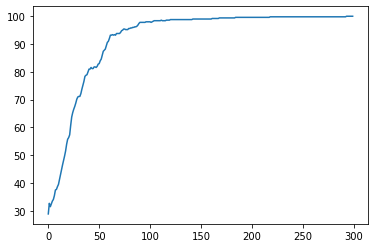

In [73]:
# hybrid model L_S 

# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt

class LSLayer(tf.keras.layers.Layer):
    
    def __init__(self,  num_outputs_s, num_outputs_l, activation=sigmoid, wstd = 0.3, bstd = 0.5):
        super(LSLayer, self).__init__()
        self.num_outputs_l = num_outputs_l
        self.num_outputs_s = num_outputs_s
        self.num_outputs = num_outputs_l + num_outputs_s
        self.activation = activation
        self.wstd = wstd
        self.bstd = bstd

        
    def build(self, input_shape):  
        self.kernel = self.add_weight("kernel",
                                      shape=(int(input_shape[-1]),
                                             self.num_outputs), 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=self.wstd),
                                     trainable=True)
        
        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=self.bstd),
                                   trainable=True)

    
    # F2 method LS layer
    def call(self, input):
        
        isp = input.shape
        In1 = tf.transpose(input)
        kernel_S, kernel_L  = tf.split(self.kernel,[ self.num_outputs_s, self.num_outputs_l ], axis = 1 )
        bias_S, bias_L  = tf.split(self.bias,[ self.num_outputs_s, self.num_outputs_l ], axis = 0 )
        
        # case spherical
        
        s_shape  = self.num_outputs_s
        In2 = tf.stack([In1] * s_shape)
        InD = tf.transpose(In2)
        WD = tf.stack([kernel_S] * isp[0])
        ddd = WD - InD
        dd0 = tf.math.multiply(ddd, ddd)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        d_r = tf.cast(dd3,tf.float32)
        d_R = tf.abs(bias_S)
        d_rR = tf.math.divide_no_nan(d_r,d_R)
        d_x0 = tf.ones(d_rR.shape) - d_rR
        result_S = tf.math.scalar_mul(6,d_x0)
        result_S = sigmoid(result_S)
        
        # case linear
        
        d_1 = tf.stack([bias_L] * isp[0])
        result_L = tf.matmul(input, kernel_L) + d_1 
        result_L = relu(result_L)
        
        # merge
        
        result = tf.concat([result_S, result_L],axis=1)
        
        return result
    

class NN_Model(Model):
    
    def __init__(self,c,l,n,m,hs,hl):
        self.C=c
        self.L=l
        self.N=n
        self.M=m
        self.HS = hs
        self.HL = hl
        super(NN_Model, self).__init__()
        self.d1 = LSLayer(self.HS,self.HL)
        self.d2 = Dense(self.C)

    def call(self, x):
        x = self.d1(x)
        #print ("call benn:",x, tf.math.reduce_sum(x))
        return self.d2(x)


@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = model(datas, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

C= 6
L= 50
N= 5000
M= 6
HS = 0
HL = 35
EPOCHS = 300

# Create an instance of the model
model = NN_Model(C,L,N,M,HS,HL)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
print (x_train[:2])
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
#print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    


X = []
Y = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for datas, labels in train_ds:
        train_step(datas, labels)
        
                
    for test_datas, test_labels in test_ds:
        #print ("test_data_shape", test_datas.shape)
        predictions = model(test_datas, training=False)
        #print ("ttttttttttttttttttt")
        #for i in range(test_datas.shape[0]):
        #    print (predictions.numpy()[i], test_labels.numpy()[i])
        test_step(test_datas, test_labels)
    
    X.append(epoch)
    Y.append(test_accuracy.result() * 100)
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
      )    

plt.plot(X, Y,label="Accuracy curve")



In [69]:
import statistics 

x = [92,75,77,74,87,75,68,81,76,80]
print (sum(x)/len(x), statistics.stdev(x))

78.5 6.883958809354461


In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


tf.enable_eager_execution()


def gen_cluster_data_list(Cv, Lv, Nv, Mv):
    Tr = []
    Ts = []
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    X, y = make_blobs(n_samples=N, centers=L, n_features=M,cluster_std=.5, random_state=11)
    cmap = []
    for _ in range(L):
        cmap.append(random.randint(0,C-1))
    cols = []
    for i in range(N):
        cols.append(cmap[y[i]])

    for i in range(int(0.9*N)):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Tr.append(row)
    
    for i in range(int(0.9*N)+1,N):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Ts.append(row)
        
    return (Tr, Ts)

def normalize (train):
    mx = []
    mn = []
    for i in range(len(train[0])-1):
        mx.append(max([x[i] for x in train ]))
        mn.append(min([x[i] for x in train ]))
    for row in train:
        for i in range(len(row)-1):
            row[i] = (row[i] - mn[i]) / (mx[i] - mn[i]) 
    return train


def gen_data_array(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,C))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i,row[-1]] = 1

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,C))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i, row[-1]] = 1
        
    return (x2_train,y2_train, x2_test, y2_test)

def gen_data_array_s(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,1))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i] = row[-1]

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,1))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i] = row[-1]
        
    return (x2_train,y2_train, x2_test, y2_test)

